# 问题四

## 导入需要使用的库

In [1]:
from PIL import Image as im
from tqdm import tqdm_notebook as tn
import numpy as np
import torch as t
import matplotlib.pyplot as plt

## 进行照片读入

In [2]:
l1 = im.open('-100.png')
l2 = im.open('-65.png')
l3 = im.open('-30.png')
l4 = im.open('0.png')
l5 = im.open('50.png')
l6 = im.open('100.png')
l2_target = im.open('-65_target.png')
l3_target = im.open('-30_target.png')
l4_target = im.open('0_target.png')

### 进行图片数据预处理

In [3]:
def compress (img,num):
    a1,a2 = img.size
    img = img.resize((int(a1/num),int(a2/num)))
    return img

In [4]:
l1 = compress(l1,4)
l2 = compress(l2,4)
l3 = compress(l3,4)
l4 = compress(l4,4)
l5 = compress(l5,4)
l6 = compress(l6,4)
l2_target = compress(l2_target,4)
l3_target = compress(l3_target,4)
l4_target = compress(l4_target,4)
l1_array = np.array(l1)
l2_array = np.array(l2)
l3_array = np.array(l3)
l4_array = np.array(l4)
l5_array = np.array(l5)
print(l5_array.shape)
l6_array = np.array(l6)
l2_target_array = np.array(l2_target)
l3_target_array = np.array(l3_target)
l4_target_array = np.array(l4_target)

(756, 1008, 3)


## 在不进行模板匹配的情况下使用SSD算法进行匹配

In [5]:
def SSD (pic,target):
    DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
    pic = t.tensor(np.array(pic)).to(DEVICE)
    target = t.tensor(np.array(target)).to(DEVICE)
    mistake_best = 99999999999999 #随便设了一个很大的值
    x_best = y_best = x_edge = y_edge = 0
    x_pic,y_pic,z_pic = pic.shape
    x_target,y_target,z_target = target.shape
    while (x_edge + x_target <= x_pic):
        y_edge = 0
        #if x_edge % 10 == 0:
        #   print(x_edge)
        while (y_edge + y_target <= y_pic):
            mistake1 = pic[x_edge : x_edge + x_target,y_edge : y_edge + y_target] - target
            #print(mistake1)
            mistake2 = mistake1 * mistake1
            #print(mistake2)
            mistake_num = mistake2.sum()
            #print(mistake_num)
            if mistake_num < mistake_best:
                mistake_best = mistake_num
                #print(mistake_best)
                x_best = x_edge
                y_best = y_edge
                #print(x_best)
            y_edge += 1
        x_edge += 1
    print(x_best,y_best)
    return x_best,y_best


In [6]:
def SSDtemplate(pic,target):
    print(pic.shape)
    print(target.shape)
    x_pic,y_pic,z_pic = pic.shape
    x_target,y_target,z_target = target.shape
    x_best,y_best = SSD(pic,target)
    pic_template = pic[x_best : x_best + x_target,y_best : y_best + y_target]
    pic_template = im.fromarray(np.uint8(pic_template))
    return pic_template

(756, 1008, 3)
(73, 192, 3)
635 90


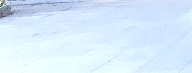

In [7]:
#print(l5_array.dtype)
#print(l2_target_array.dtype)
test = SSDtemplate(l5_array,l4_target_array)
test

+ 显然SSD算法很笨，对于曝光程度相差很大的图片无法匹配
+ 想要用上SSD算法做模板匹配，必须要先做直方图特例化

## 直方图特例化后做SSD模板匹配

In [8]:
def cdf (array):
    a = array.shape[0]
    sum_array = np.zeros(a)
    for num in range(a):
        if num == 0:
            sum_array[0] = array[0]
        else:
            sum_array[num] = array[num] + sum_array[num-1]
    return sum_array 

In [9]:
def statistics(array):
    x,y = array.shape
    result = np.zeros(256)
    for i in range(0,x-1):
        for j in range (0,y-1):
            result[array[i-1][j-1]] += 1
    result = result/result.sum()
    return result

In [10]:
def map_sp(cdf1,cdf2):
    x = cdf1.shape[0]
    #print(x)
    map_array = 255 * np.ones(x)
    for i in range(0,x):
          for j in range(0,x):
            if cdf2[j] >= cdf1[i]:
                map_array[i] = j
                break;
    #print(map_array)
    return map_array

In [11]:
def map_special_3d(array,cdf_target,cdf_pic):
    x_sp,y_sp,z_sp = array.shape
    l_mapsp = np.zeros((x_sp,y_sp,z_sp))
    for k in range(z_sp):
        map_rel = map_sp(cdf_target[k-1,:],cdf_pic[k-1,:])
        #print(map_rel)
        for i in range(x_sp):
            for j in range(y_sp):
                l_mapsp[i,j,k] = map_rel[array[i,j,k]]
   # l_mapsp = np.int(l_mapsp)
    return l_mapsp

In [12]:
def cdf_3d(array):
    array_cdf = np.zeros((3,256))
    for i in range(3):
        array_cdf[i,:] = cdf(statistics(array[:,:,i]))
    return array_cdf

In [13]:
def SSDtemplate_equ(pic,target,pic_target):
    pic_cdf = cdf_3d(pic)
    target_cdf = cdf_3d(pic_target)
    target_array_map = map_special_3d(target,target_cdf,pic_cdf)
    target_array_map = target_array_map.astype(np.uint8)
    #print(target_array.dtype)
    #print(target_array_map[:,:,2])
    test = SSDtemplate(pic,target_array_map)
    return test

(756, 1008, 3)
(64, 182, 3)
267 431


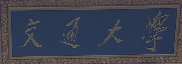

In [14]:
test = SSDtemplate_equ(l1_array,l3_target_array,l3_array)
test

## ZNCC算法解决模板匹配问题

In [15]:
def ZNCC (pic,target):
    DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
    pic = t.tensor(np.array(pic),dtype = t.float).to(DEVICE)
    target = t.tensor(np.array(target),dtype = t.float).to(DEVICE)
    pic_shape = pic.shape
    target_shape = target.shape
    position_best = [0,0]
    loss_best = -2
    pic__nor = t.ones_like(pic)
    pic_mean = t.ones_like(pic) 
    target_nor = t.ones_like(target) 
    target_mean = t.ones_like(target) 
    for i in range(3):
        target_mean[:,:,i] = (t.sum(target[:,:,i])/(target_shape[0] * target_shape[1])) * t.ones_like(target[:,:,i])
        pic_mean[:,:,i] = (t.sum(pic[:,:,i])/(pic_shape[0] * pic_shape[1])) * t.ones_like(pic[:,:,i])
    target_nor = target - target_mean
    pic_nor = pic - pic_mean
    for i  in range(pic_shape[0] - target_shape[0]):
        for j in range(pic_shape[1] - target_shape[1] + 1):
            tmp = pic_nor[i:i + target_shape[0],j:j + target_shape[1]]
            loss = t.sum(target_nor / t.sqrt(t.sum(target_nor * target_nor)) * (tmp / t.sqrt(t.sum(tmp * tmp))))
            if loss > loss_best:
                loss_best = loss
                position_best = [i, j]
    print(position_best)
    return position_best

In [16]:
def ZNCCtemplate(pic,target):
    pic_shape = pic.shape
    target_shape = target.shape
    #print(target_shape)
    position = ZNCC(pic,target)
    #print(pic[position[0]:position[0]+target_shape[0],position[1]:position[1]+target_shape[1]].shape)
    return im.fromarray(pic[position[0]:position[0]+target_shape[0],position[1]:position[1]+target_shape[1],:].astype('uint8'))

[263, 431]


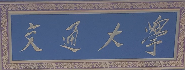

In [17]:
test = ZNCCtemplate(l3_array,l2_target_array)
test

+ 测试了不同曝光度下的模板匹配（示例为图二图三）
+ ZNCC算法可以很好的应对曝光程度不同的问题